In [1]:
# Python imports
import numpy as np # Matrix and vector computation package
np.seterr(all='ignore') # ignore numpy warning
import matplotlib.pyplot as plt  # Plotting library
import scipy.special # get sigmoid function
# Allow matplotlib to plot inside this notebook
%matplotlib qt 
from sklearn import datasets, cross_validation, metrics # data and evaluation utils
from matplotlib.colors import colorConverter, ListedColormap # some plotting functions
import itertools 
import collections
from batchup import data_source # create batches from data

/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
class NeuralNetwork:    
    #initialize the neural network
    def __init__(self):
        """
        initialization of neural networks
        """
        self.load_dataset()
        self.neural_network_functions()
        pass
            
    def load_dataset(self):
        """
        load and split the data into train, test and validation set
        """
        iris = datasets.load_iris() # load dataset

        # Load the targets and convert them to 
        # one-hot-encoding for the output softmax layer.
        self.T = np.zeros((iris.target.shape[0],3))
        self.T[np.arange(len(self.T)), iris.target] += 1
                                
        # Divide the data into a train and test set.
        self.X_train, self.X_test, self.T_train, self.T_test = cross_validation.train_test_split(iris.data,
                                                                                                 self.T,
                                                                                                 test_size=0.3,
                                                                                                 random_state = 10)
        
        # Divide the test set into a validation set and final test set.
        self.X_validation, self.XV_test, self.T_validation, self.TV_test = cross_validation.train_test_split(self.X_test,
                                                                                                             self.T_test,
                                                                                                             test_size=.5)
        pass
    
    def neural_network_functions(self):        
        """
        it contains non-linear functions:
        1.) activation functions: sigmoid, softmax, 
        2.) cost function: cross_entropy
        3.) gradients : sigmoid, 
        4.) learning rule: weight update(delta_w)
        """        
        #sigmoid
        self.sigmoid = lambda x: scipy.special.expit(x)                
        #softmax
        self.softmax = lambda z : np.exp(z) / np.sum(np.exp(z), axis=1, keepdims=True)
        #cross_entropy or cost function
        self.cross_entropy_loss = lambda y, t: - np.sum(np.multiply(t, np.log(y)) + np.multiply((1-t), np.log(1-y)))    
        #gradients
        self.gradient = lambda w, x, t: (self.nn(x, w) - t).T * x
        #sigmoid derivative                
        self.sigmoid_gradient = lambda y: np.multiply(y, (1 - y))
        #update delta w
        #self.delta_w = lambda w_k, x, t, learning_rate: learning_rate * self.gradient(w_k, x, t)                
        pass    
    
       
    #Training of model involves two steps:
    #1.) forward propagation
    #2.) backward propagation
    def forward_propagation_step(self, inputs, list_of_layer):
        """
        Forward propagation: it is used to calculate the activations(or outputs) of all layers including 
        the inputs to the layer and stores them in a list 
        """
        n_layer_activations = [inputs]    # initialize the list with input
        x = inputs                        # initialize variable "x" with inputs
        for nth_layer in list_of_layer:   # access each layer iteratively 
            y = nth_layer.get_output(x)   # get output from nth-layer
            n_layer_activations.append(y) # save nth-layer output in activation list        
            x = n_layer_activations[-1]   # get the last layer activation values and make it input for next layer
            pass        
        return n_layer_activations        # return a list of activations of every layer

    def back_propagation_step(self, list_of_activations, targets, list_of_layer):
        """
        Backpropagation step:
        it involves updating the parameter in the model        
        """
        param_grads = collections.deque()
        output_grad = None

        for nth_last_layer in reversed(list_of_layer): # access every layer from the last layer
            y = list_of_activations.pop()              # get activations from last layer and delete the 
                                                       # last layer from the list
            if output_grad is None:                    # if there is no gradient in the output layer
                input_grad = nth_last_layer.get_input_grad(y, targets)
                pass
            else :
                input_grad = nth_last_layer.get_input_grad(y, output_grad)
                pass

            x = list_of_activations[-1]                            # get activation from the last layer 
            grads = nth_last_layer.get_params_grad(x, output_grad) # get parameters of gradient 
                                                                   # between nth and (n-1)th layer.
                                                                   # these are change weights and bias
            param_grads.appendleft(grads)                          # make a list of parameter gradients
            
            output_grad = input_grad
            
        return list(param_grads) # return list of parameters
    
    # Define a method to update the parameters(or  weights)
    def delta_weight(self, list_of_layer, param_grads, learning_rates):
        """
        Function to update the parameters of the given layers with the given gradients
        by gradient descent with the given learning rate.      
        """     
        for layer, layer_backprop_grads in zip(list_of_layer, param_grads):        
            for param, grad in zip(layer.get_params_iter(), layer_backprop_grads): #access each parameter and gradient
                param -= learning_rates * grad # Update each parameter using gradient descent
                pass
            pass
        pass
    
    def train(self, list_of_layer, X_train, T_train, epochs, learning_rates):        
        """
        Perform training of data using forward and back propagation functions 
        given above and store the training and validation costs in every epoch
        for future analsis.
        """        
        training_costs = []   # initialize list to store the costs of training in every epoch
        validation_costs = [] # initialize list to store the costs of validation in every epoch
        
        # Construct an array of data source
        ds = data_source.ArrayDataSource([X_train, T_train]) # use training data and its target labels                
        
        print ("Waiting for the model to be trained ...")        
        for epoch in range(epochs): # Training with maximum number of epochs
            # Iterate over samples and use batches of 25 samples in a random order
            for X_train_data, T_label in ds.batch_iterator(batch_size=25, shuffle=np.random.RandomState(25)): 
                # get a list of activations from all layers
                activations = self.forward_propagation_step(X_train_data,     # sample of batch
                                                            list_of_layer)    # list of layer                
                # get list of parameter gradients
                param_grads = self.back_propagation_step(activations,         # activations from forward propagation
                                                         T_label,             # labels of samples in a batch
                                                         list_of_layer)       # list of layer                
                # Update parameters(or weights) using gradient descent
                self.delta_weight(list_of_layer,  # list of layer
                                  param_grads,    # parameter gradients
                                  learning_rates) # learning rate

            # Get full training cost in a list
            # get activations(or output) of every layer in a list
            activations = self.forward_propagation_step(X_train,         # training data
                                                        list_of_layer)   # list of layer
            # get training cost at the last layer
            train_cost = list_of_layer[-1].get_cost(activations[-1],     # output from last layer
                                                    T_train)             # training label at the output
            # append list of training cost for every epoch
            training_costs.append(train_cost)                            
            
            # Get full validation cost in a list
            # get activations(or output) of every layer in a list from validation data
            activations = self.forward_propagation_step(self.X_validation, # validation data
                                                        list_of_layer)     # list of layer
            # get validation cost at output layer
            validation_cost = list_of_layer[-1].get_cost(activations[-1],   # output from last layer
                                                         self.T_validation) # validation label at the output
            # append list of validation cost for every epoch
            validation_costs.append(validation_cost) 

            
            if len(validation_costs) > 3: # Stop training if the cost on the validation 
                                          # set doesn't decrease for 3 iterations
                if validation_costs[-1] >= validation_costs[-2] >= validation_costs[-3]:
                    break

        #nb_of_epochs = epoch + 1  # total number of epochs that have been executed
        print ("Model trained !")
        return training_costs

    def test_accuracy(self, list_of_layer, X_test, T_test):   
        """
        Get the test accuracy of the test data on the trained model
        """
        y_true = np.argmax(T_test, axis=1)                                  # Get the target outputs
        activations = self.forward_propagation_step(X_test, list_of_layer)  # Get activation of test samples
        y_pred = np.argmax(activations[-1], axis=1)  # Get the predictions made by the network
        test_accuracy = metrics.accuracy_score(y_true, y_pred)  # Get test set accuracy
        print('The accuracy on the test set is {:.2f}'.format(test_accuracy))
        pass
    
    def plot_cost_vs_epochs(self, nb_of_epochs, training_costs):
        """
        Evaluate the performce of the model by plotting the graph between 
        cost and epochs
        """
        # Plot full training costs
        epoch_x_inds = np.linspace(1, nb_of_epochs, num=nb_of_epochs)
        # Plot the cost over the iterations
        plt.plot(epoch_x_inds, training_costs, 'r-', linewidth=3, label='cost full training set')
        # Add labels to the plot
        plt.xlabel('Epochs --->')
        plt.ylabel('$Error --->$', fontsize=15)
        plt.title('cost vs epochs')
        plt.legend()
        x1,x2,y1,y2 = plt.axis()
        plt.axis((0,nb_of_epochs,0,2.5))
        plt.grid()
        plt.show()
        pass
    

In [3]:
# For our application we need three different kinds of layers:
# 1.) Linear layer
# 2.) Sigmoid/Logistic layer
# 3.) Softmax layer
# for these three layers we need a base class, which
# can share some function among the three given layer


# Base class with common methods among the layers
# used in the model
class BaseLayer(object):
    """
    Base class for three different layers:
    This class contains some basic methods which 
    are used among the three different types of layers 
    used in the given model of neural network.
    """
    
    def get_params_iter(self):
        """
        Return an iterator over the parameters (if any).
        The iterator has the same order as get_params_grad.
        The elements returned by the iterator are editable in-place.
        """
        return []
    
    def get_params_grad(self, X, output_grad):
        """
        Return a list of gradients over the parameters.
        The list has the same order as the get_params_iter iterator.
        1.) "X" is the input.
        2.) "output_grad" is the gradient at the output of the given layer.
        """
        return []
    
    def get_output(self, X):
        """
        performs linear transformation in the feed forward step.
        and it will act as an input to the next layer(or to the
        activation layer).
        1.) "X" is the input.
        """
        pass
    
    def get_input_grad(self, Y, output_grad=None, T=None):
        """
        During backpropagation, it returns the gradient
        of the input of the given given layer.        
        1.) "Y" is the pre-computed output of the given layer
        during forward propagation.         
        2.) For the output layer instead of using "Y", output
        layer uses the Target "T" to compute the gradient 
        instead of using the output_grad.        
        3.) "output_grad" is the gradient at the output of the given layer
        """
        pass

In [4]:
class LinearLayer(BaseLayer):
    """
    "Linear Layer" performs a linear transformation to its input.
    Please note that every layer has two steps:
    1.) forward propagation: involves calculating linear transformation, 
    activation functions    
    2.) backprogation: involves parameter updating(or weight updating)
    calculating gradient or error at the output of the given layer
    """    
    def __init__(self, 
                 no_of_input_nodes, 
                 no_of_output_nodes):
        # linear layers initializes the weights and bias 
        # between the two consecutive layers whereas as rest
        # of the layers are responsible for the computation 
        # of non-linear (or activation functions) functions.        
        self.W = np.random.randn(no_of_input_nodes, # number of input variables
                                 no_of_output_nodes # number of output variables
                                ) * 0.1            
        self.b = np.zeros(no_of_output_nodes) # bias initialized with zero
        pass
        
    # forward propagation step
    def get_output(self, X):
        """
        Performs the linear transformation for the forward 
        step which will act as an input to the activation layer.
        """
        return X.dot(self.W) + self.b
    
    # forward propagation step or used for paramater update
    def get_params_iter(self):
        """
        Return an iterator over the parameters.
        """
        return itertools.chain(np.nditer(self.W, op_flags=['readwrite']),
                               np.nditer(self.b, op_flags=['readwrite']))
    
    # backpropagation step
    def get_params_grad(self, X, output_grad):
        """
        During the backpropagation it returns a list 
        of gradients over the parameters(or weight and
        parameters)
        """
        JW = X.T.dot(output_grad)
        Jb = np.sum(output_grad, axis=0)
        return [g for g in itertools.chain(np.nditer(JW), np.nditer(Jb))]
    
    # backpropagation step
    def get_input_grad(self, Y, output_grad):
        """
        Returns the gradient(or error) at the inputs of
        the given layer.
        """
        return output_grad.dot(self.W.T)

In [5]:
#logistic layer
class SigmoidLayer(BaseLayer, NeuralNetwork):
    """
    "Logistic Layer": computes the logistic or sigmoid
    function from the output of the "Linear Layer"
    Please note that every layer has two steps:
    1.) forward propagation: involves calculating linear transformation, 
    activation functions    
    2.) backprogation: involves parameter updating(or weight updating)
    calculating gradient or error at the output of the given layer
    """
    
    # forward propagation step:
    def get_output(self, X):
        """
        Perform the forward step transformation.
        """
        return self.sigmoid(X)
    
    # backpropagation step
    def get_input_grad(self, Y, output_grad):
        """
        Return the gradient at the inputs of this layer.
        """
        return np.multiply(self.sigmoid_gradient(Y), output_grad)

In [6]:
#softmax layer
class SoftmaxLayer(BaseLayer, NeuralNetwork):
    """
    The softmax output layer computes the classification propabilities at the output.
    Please note that every layer has two steps:
    1.) forward propagation: involves calculating linear transformation, 
    activation functions    
    2.) backprogation: involves parameter updating(or weight updating)
    calculating gradient or error at the output of the given layer
    """
    #forward propagation
    def get_output(self, X):
        """
        Perform the forward step transformation.
        """
        return self.softmax(X)
    
    #backward propagation
    def get_input_grad(self, Y, T):
        """
        Return the gradient at the inputs of this layer.
        """
        return (Y - T) / Y.shape[0]
    
    # for testing the network on the large training data
    def get_cost(self, Y, T):
        """
        Cross-Entropy cost function
        Return the cost at the output of this output layer.
        """
        return - np.multiply(T, np.log(Y)).sum() / Y.shape[0]

Waiting for the model to be trained ...
Model trained !


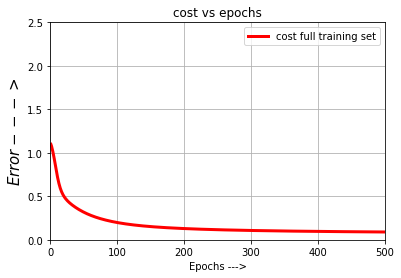

The accuracy on the test set is 0.96


In [7]:
if __name__ == "__main__":    
    """
    Create and train a model
    sample of model with layers is :
    input layer -> linear layer -> sigmoid layer-> linear layer -> sigmoid layer -> linear layer -> softmax layer
    """
    # instantiate neural network class
    ANN = NeuralNetwork()
    
    # add nodes(or neurons) in the hidden layer,
    no_of_hidden_nodes_layer_1 = 25 # hidden layer 1  
    no_of_hidden_nodes_layer_2 = 15 # hidden layer 2  (not required)
    no_of_hidden_nodes_layer_3 = 20 # hidden layer 3  (not required)
    
    list_of_layers = [] # store layers in a list
    
    # please note: For our architecutre 
    # one hidden layer is a combination of "Linear layer + sigmoid layer"
    # and output layer is a combination of "Linear layer + softmax layer"
    
    # Add first hidden layer: 
    list_of_layers.append(LinearLayer                   # add "Linear layer" and arguments are :
                         (ANN.X_train.shape[1],         # 1.) number of input nodes
                          no_of_hidden_nodes_layer_1))  # 2.) number of hidden nodes
    list_of_layers.append(SigmoidLayer())               # add "Sigmoid layer"
    
    # Add second hidden layer
    # list_of_layers.append(LinearLayer
                          # (no_of_hidden_nodes_layer_1, 
                          # no_of_hidden_nodes_layer_2))
    # list_of_layers.append(SigmoidLayer())    
    """
    Here you can add "N" number of layers exactly in the same way as above......
    Examples are :
    # list_of_layers.append(LinearLayer
                            (no_of_nodes_in_nth_hidden_layer, 
                             no_of_nodes_in_nth+1_hidden_layer))
    # list_of_layers.append(SigmoidLayer())                                        
    """
    # Add output layer
    list_of_layers.append(LinearLayer                   # add "Linear Layer" and arguments are:
                         (no_of_hidden_nodes_layer_1,   # 1.) number of input nodes
                          ANN.T_train.shape[1]))        # 2.) number of output nodes    
    list_of_layers.append(SoftmaxLayer())               # add softmax layer
    # model created upto this point
        
        
    # After model creation, train the model
    # and get training costs
    no_of_epochs = 500    # set number of epochs for training
    learning_rate = 0.15  # set learning rate for training
    
    training_costs = ANN.train(list_of_layers, # layers stored in a list 
                               ANN.X_train,    # training data 
                               ANN.T_train,    # training labels
                               no_of_epochs,   # number of epochs 
                               learning_rate)  # learning rate
        
    # plot the graph between the training costs and the number of epochs        
    ANN.plot_cost_vs_epochs(no_of_epochs,   # number of epochs
                            training_costs) # list of training costs in every epoch
    
    # test accuracy of the network
    ANN.test_accuracy(list_of_layers,  # layers stored in a list
                      ANN.XV_test,     # validation test data
                      ANN.TV_test)     # validation test training labels
    